The objective of this program is to be able to identify moles as cancerous or as benign based on their photo using the Kaggle dataset

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import umap
import warnings
import tensorflow as tf
from keras.models import load_model
from glob import glob
from PIL import Image
import seaborn
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Conv2D, Flatten, MaxPool2D, Dense
from tensorflow.keras import layers
from keras.preprocessing.image import ImageDataGenerator
from imblearn.over_sampling import RandomOverSampler 
warnings.filterwarnings('ignore')

Using TensorFlow backend.


Now we load the appropriate datasets and we also label the lesion types.

In [2]:
data = pd.read_csv('hmnist_28_28_RGB.csv')
y = data['label']
x = data.drop(columns = 'label')


Lesion_types = {'cbc' : 'Base cell carcinoma',
                'bkl' : 'Benign keratosis',
                'akiec' : 'Actinic keratosis',
                'df' : 'Dermafibromatosis',
                'mel' : 'Melanoma',
                'nv' : 'New Melanocites',
                'vasc' : 'Vascular Lesion',
               }

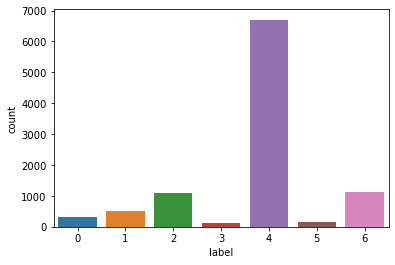

In [3]:
seaborn.countplot(y)

In [4]:
x = (x-np.mean(x))/np.std(x)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = .3)

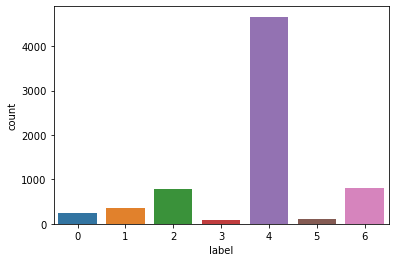

In [5]:
seaborn.countplot(y_train)

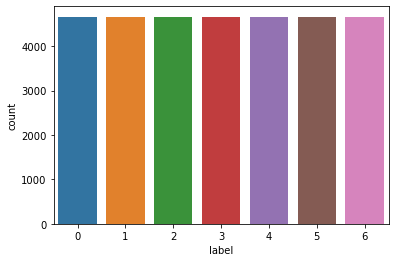

In [6]:
oversample = RandomOverSampler()
x_train,y_train = oversample.fit_resample(x_train,y_train)
seaborn.countplot(y_train)

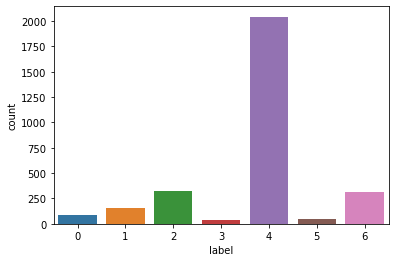

In [7]:
seaborn.countplot(y_test)

In [5]:
x_train = np.array(x_train).reshape(-1,28,28,3)
x_test = np.array(x_test).reshape(-1,28,28,3)

In [6]:
# With data augmentation to prevent overfitting 

datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=0,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=True,  # randomly flip images
        vertical_flip=True)  # randomly flip images
datagen.fit(x_train)

Here we will create a convolutional neural network with the goal of identifying the type of lesions present.

In [7]:
model = tf.keras.models.Sequential()
model.add(Conv2D(16, kernel_size = (3,3), input_shape = (28, 28, 3), activation = 'relu', padding = 'same'))
model.add(Conv2D(32, kernel_size = (3,3), activation = 'relu'))
model.add(MaxPool2D(pool_size = (2,2)))
model.add(Conv2D(32, kernel_size = (3,3), activation = 'relu', padding = 'same'))
model.add(Conv2D(64, kernel_size = (3,3), activation = 'relu'))
model.add(MaxPool2D(pool_size = (2,2), padding = 'same'))
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(7, activation='softmax'))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 16)        448       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 26, 26, 32)        4640      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 13, 13, 32)        9248      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 11, 11, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 6, 6, 64)          0         
_________________________________________________________________
flatten (Flatten)            (None, 2304)              0

In [8]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [9]:
# Fit the model
epochs = 50 
batch_size = 10
history = model.fit_generator(datagen.flow(x_train,y_train, batch_size=batch_size),
                              epochs = epochs, validation_data = (x_test,y_test),
                              verbose = 1, steps_per_epoch=x_train.shape[0] // batch_size)

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/50
701/701 [==============================] - 24s 34ms/step - loss: 0.9406 - accuracy: 0.6743 - val_loss: 0.9106 - val_accuracy: 0.6842
Epoch 2/50
701/701 [==============================] - 21s 30ms/step - loss: 0.8521 - accuracy: 0.6872 - val_loss: 0.8835 - val_accuracy: 0.6819
Epoch 3/50
701/701 [==============================] - 22s 31ms/step - loss: 0.8169 - accuracy: 0.7010 - val_loss: 0.8268 - val_accuracy: 0.7078
Epoch 4/50
701/701 [==============================] - 24s 34ms/step - loss: 0.7915 - accuracy: 0.7134 - val_loss: 0.8019 - val_accuracy: 0.7015
Epoch 5/50
701/701 [==============================] - 22s 31ms/step - loss: 0.7723 - accuracy: 0.7146 - val_loss: 0.7762 - val_accuracy: 0.7205
Epoch 6/50
701/701 [==============================] - 21s 30ms/step - loss: 0.7436 - accuracy: 0.7275 - val_loss: 0.7766 - val_accuracy: 0.7291
Epoch 7/50
701/701 [==============================] - 22s 31

KeyboardInterrupt: 

In [ ]:
model.evaluate(x_test, y_test)

In [ ]:
for i in range(10):
    image = datagen.flow(np.array([x_train[i]]),np.array([y_train[i]]), batch_size=1)[0]
    plt.imshow(image[0][0])
    plt.show()
    plt.imshow(x_train[i])
    plt.show()